In [40]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.signal import argrelmin

import csv
import os

In [3]:
def transform_to_density(b_values, Ic_values, y_values):
    W = 360
    L = 100
    omega = 2 * np.pi / W

    phi_values = b_values * W * L
    dPhi = phi_values[1] - phi_values[0]
    maxPhi = phi_values[-1]

    real, imag = Ic_values

    Jy_values = []
    for y in y_values:
        Jy_real = 0
        Jy_imag = 0
        for k, phi in enumerate(phi_values):
            Ic_real = real[k] #Fourier coefficient
            Ic_imag = imag[k]
            Jy_real += np.cos(np.pi * phi / (2 * maxPhi))**0.5 *(Ic_real * np.cos(omega * phi * y) - Ic_imag * np.sin(omega * phi * y)) * dPhi
            Jy_imag += np.cos(np.pi * phi / (2 * maxPhi))**0.5 *(Ic_imag * np.cos(omega * phi * y) + Ic_real * np.sin(omega * phi * y)) * dPhi

        Jy_abs = np.sqrt(Jy_real**2 + Jy_imag**2)
        Jy_values.append(Jy_abs)
    return(Jy_values)


In [4]:
def flip_minima(abs_values, real_values):
    main_peak = np.argmax(abs_values)
    left_min = [0]
    right_min = [main_peak]
    for localmin in argrelmin(abs_values, order=2)[0]:
        if localmin < main_peak:
            left_min.append(localmin)
        else:
            right_min.append(localmin)
    left_min.append(main_peak)
    right_min.append(len(abs_values))
    left_min_rev = list(reversed(left_min))

    osc = []
    n = len(left_min)
    for i in range(n - 1):
        for index in range(left_min_rev[n  - i - 1], left_min_rev[n - i - 2]):
            osc.append((-1)**(n - i) * abs(real_values[index]))
    for i in range(n - 1):
        for index in range(right_min[i], right_min[i+1]):
            osc.append((-1)**i * abs(real_values[index]))
    return(osc)

In [5]:
def read_values(filename):
    result = []
    with open(filename) as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
            result.append([float(element) for element in row])
    return(result)


In [6]:
directory = '/users/tkm/kanilmaz/thesis/results/wg3_2/supercurrent/use/'

dirpath, dirnames, filenames = list(os.walk(directory))[0]


In [71]:
magnetic_field = np.linspace(0, 1, 10)
vsg_values = np.linspace(3, 4, 8)

In [72]:
result = []
for i, b in enumerate(magnetic_field):
    for j, v in enumerate(vsg_values):
        result.append(((i, j), i + j))


In [73]:
sorted_res = list(zip(*sorted(result, key=lambda value: value[0])))

In [78]:
final = np.split(np.asarray(sorted_res[1]), len(vsg_values))

In [79]:
final

[array([0, 1, 2, 3, 4, 5, 6, 7, 1, 2]),
 array([3, 4, 5, 6, 7, 8, 2, 3, 4, 5]),
 array([6, 7, 8, 9, 3, 4, 5, 6, 7, 8]),
 array([ 9, 10,  4,  5,  6,  7,  8,  9, 10, 11]),
 array([ 5,  6,  7,  8,  9, 10, 11, 12,  6,  7]),
 array([ 8,  9, 10, 11, 12, 13,  7,  8,  9, 10]),
 array([11, 12, 13, 14,  8,  9, 10, 11, 12, 13]),
 array([14, 15,  9, 10, 11, 12, 13, 14, 15, 16])]

In [80]:

y, x = np.meshgrid(magnetic_field, vsg_values)
z = final

/home/nefta/.virtualenvs/kwant/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['xkcd', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


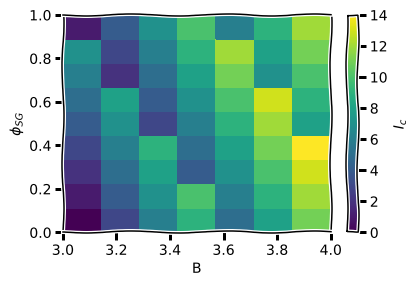

In [90]:
plt.pcolor(x, y, z)
cb = plt.colorbar()
cb.set_label(r'$I_c$')
plt.xlabel('B')
plt.ylabel(r'$\phi_{SG}$')